In [1]:
import pickle as pkl
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import matplotlib.pyplot as plt
import math
import os
import pickle

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pkl.load(fo, encoding='bytes')
    return dict

In [3]:
def load_cifar(path = "cifar-10-python/cifar-10-batches-py"):
    train_batches = []
    train_labels = []

    for i in range(1, 6):
        cifar_out = unpickle(os.path.join(path, "data_batch_{0}".format(i)))
        train_batches.append(cifar_out[b"data"])
        train_labels.extend(cifar_out[b"labels"])
    X_train= np.vstack(tuple(train_batches)).reshape(-1, 3, 32, 32)
    y_train = np.array(train_labels)

    cifar_out = unpickle(os.path.join(path, "test_batch"))
    X_test = cifar_out[b"data"].reshape(-1, 3, 32, 32)
    y_test = cifar_out[b"labels"]
    
    X_train = (X_train / 255.0).astype(np.float32) 
    X_test = (X_test / 255.0).astype(np.float32) 
    mean = X_train.mean(axis = (0, 2, 3)) 
    std = X_train.std(axis = (0, 2, 3)) 
    X_train = (X_train - mean[:, None, None]) / std[:, None, None]
    X_test = (X_test - mean[:, None, None]) / std[:, None, None]

    return (X_train, np.array(y_train)), (X_test, np.array(y_test))

In [4]:
(X_train, y_train), (X_test, y_test) = load_cifar()

sample_count = 5000
class_count = [0] * 10
count = 0
X_sample = np.zeros((sample_count, 3, 32, 32))
y_sample = np.zeros((sample_count))
for i in range (50000):
    for j in range (2):
        if y_train[i] == j and class_count[j] < sample_count / 2:
            X_sample[count] = np.array(X_train[i])
            y_sample[count] = np.array(y_train[i]) 
            count += 1
            class_count[j] += 1

X_train = X_sample.astype(np.float32)
y_train = y_sample.astype(np.int)
            
sample_count = 0
class_count = [0] * 10
count = 0
X_sample = np.zeros((sample_count, 3, 32, 32))
y_sample = np.zeros((sample_count))
for i in range (10000):
    for j in range (2):
        if y_test[i] == j and class_count[j] < sample_count / 2:
            X_sample[count] = np.array(X_test[i])
            y_sample[count] = np.array(y_test[i]) 
            count += 1
            class_count[j] += 1

X_test = X_sample.astype(np.float32)
y_test = y_sample.astype(np.int)

In [5]:
X = np.concatenate((X_train, X_test), axis = 0)
X = np.asarray(X).reshape(-1, 3, 1024)
y = np.concatenate((y_train, y_test))
N = X.shape[0]
d = X.shape[2]

In [6]:
print(X.shape)
print(y.shape)
print(N)
print(d)

(5000, 3, 1024)
(5000,)
5000
1024


In [7]:
# W = np.zeros((N, N))
# for i in range(N):
#     if i % 100 == 0:
#         print(i * 100.0 / N)
#     for j in range(N):
#         W[i, j] = math.exp(-npl.norm(X[i] - X[j]) ** 2 / d)
# print(100.0)

In [ ]:
# # Depth of CNTK (#Convolution Layers + 1)
# d = 3
# # Whether GAP (Global Average Pooling) is used
# gap = True
# # Whether first layer and last layer are fixed or trained
# fix = False

# #CUDA kernel for convolution operation
# conv3 = cp.RawKernel(r'''
# extern "C" __global__
# void conv3(const float s[32][32][32][32], float t[32][32][32][32])
# {
#     int x1 = threadIdx.x + blockIdx.x - 31;
#     int y1 = threadIdx.y + blockIdx.y - 31;
#     int x2 = threadIdx.x;
#     int y2 = threadIdx.y;
#     __shared__ float d[32 + 2][32 + 2];
#     if (x2 == 0){
#         d[0][y2 + 1] = d[33][y2 + 1] = 0;
#         if (x2 == 0 && y2 == 0)
#             d[0][0] = d[0][33] = d[33][0] = d[33][33] = 0; 
#     }
#     if (y2 == 0){
#         d[x2 + 1][0] = d[x2 + 1][33] = 0;
#     }
#     if (x1 < 0 || x1 > 31 || y1 < 0 || y1 > 31){
#         d[x2 + 1][y2 + 1] = 0;
#         return;
#     }
#     else
#         d[x2 + 1][y2 + 1] = s[x1][y1][x2][y2];
#     __syncthreads();
#     t[x1][y1][x2][y2] = d[x2][y2] + d[x2][y2 + 1] + d[x2][y2 + 2]
#                       + d[x2 + 1][y2] + d[x2 + 1][y2 + 1] + d[x2 + 1][y2 + 2]
#                       + d[x2 + 2][y2] + d[x2 + 2][y2 + 1] + d[x2 + 2][y2 + 2];
# }''', 'conv3')
# conv_blocks = (63, 63)
# conv_threads = (32, 32)

# #CUDA kernel for activation
# trans = cp.RawKernel(r'''
# extern "C" __global__
# void trans(float s[32][32][32][32], float t[32][32][32][32], const float l[32][32], const float r[32][32], const float il[32][32], const float ir[32][32])
# {
#     int x1 = blockIdx.x;
#     int y1 = blockIdx.y;
#     int x2 = threadIdx.x + ((blockIdx.z >> 2) << 3);
#     int y2 = threadIdx.y + ((blockIdx.z & 3) << 3);
#     float S = s[x1][y1][x2][y2], T = t[x1][y1][x2][y2], L = l[x1][y1], R = r[x2][y2], iL = il[x1][y1], iR = ir[x2][y2];
#     S = S * iL * iR;
#     float BS = (S * (3.141592654f - acosf(max(min(S, 1.0f), -1.0f))) + sqrtf(1.0f - min(S * S, 1.0f))) * L * R / 28.274333882308138f;
#     S = (3.141592654f - acosf(max(min(S, 1.0f), -1.0f))) / 28.274333882308138;
#     t[x1][y1][x2][y2] = T * S + BS;
#     s[x1][y1][x2][y2] = BS;
# }''', 'trans')
# trans_blocks = (32, 32, 16)
# trans_threads = (8, 8)

# #Calculate diagonal entries of $\Sigma^{(h)}(x, x)$ and their reciprocals
# def xx(x):
#     RL = [1.0, ]
#     iRL = [1.0, ]

#     S = cp.matmul(x.T, x).reshape(32, 32, 32, 32)
#     conv3(conv_blocks, conv_threads, (S, S))
#     T = cp.zeros((32, 32, 32, 32), dtype = cp.float32)
#     if not fix:
#         T += S

#     for i in range(1, d - 1):
#         L = cp.sqrt(cp.diag(S.reshape(1024, 1024)).reshape(32, 32))
#         iL = 1.0 / L
#         RL.append(L)
#         iRL.append(iL)
#         trans(trans_blocks, trans_threads, (S, T, L, L, iL, iL))
#         conv3(conv_blocks, conv_threads, (S, S))
#         conv3(conv_blocks, conv_threads, (T, T))

#     L = cp.sqrt(cp.diag(S.reshape(1024, 1024)).reshape(32, 32))
#     iL = 1.0 / L
#     RL.append(L)
#     iRL.append(iL)
#     trans(trans_blocks, trans_threads, (S, T, L, L, iL, iL))

#     if fix:
#         T -= S
#     return RL, iRL

# #Caclulate the kernel value of x and z.
# #Lx and Lz are diagonal entries of $\Sigma^{(h)}(x, x)$ and $\Sigma^{(h)}(z, z)$. 
# #iLx and iLz are reciprocals of diagonal entries of $\Sigma^{(h)}(x, x)$ and $\Sigma^{(h)}(z, z)$. 
# def xz(x, z, Lx, Lz, iLx, iLz):
#     S = cp.matmul(x.T, z).reshape(32, 32, 32, 32)
#     conv3(conv_blocks, conv_threads, (S, S))
#     T = cp.zeros((32, 32, 32, 32), dtype = cp.float32)
#     if not fix:
#         T += S

#     for i in range(1, d - 1):
#         trans(trans_blocks, trans_threads, (S, T, Lx[i], Lz[i], iLx[i], iLz[i]))
#         conv3(conv_blocks, conv_threads, (S, S))
#         conv3(conv_blocks, conv_threads, (T, T))

#     trans(trans_blocks, trans_threads, (S, T, Lx[-1], Lz[-1], iLx[-1], iLz[-1]))

#     if fix:
#         T -= S
#     return cp.mean(T) if gap else cp.trace(T.reshape(1024, 1024))

In [8]:
infile = open('lapreg', 'rb') 
W = pkl.load(infile)                      
infile.close() 

In [9]:
infile = open('cntk', 'rb') 
H = pkl.load(infile)                      
infile.close() 

In [10]:
n_l = N // 2
n_u = N - n_l
y = (y + 1) // 2
y_l = y[:n_l]
y_t = np.ones((n_l, 2)) * -0.1
for i in range(n_l):
    y_t[i][y_l[i]] = 0.9
u = np.dot(W[n_l:, :n_l], np.dot(npl.inv(W[:n_l, :n_l]), y_t))
y_u = np.argmax(u, axis = 1)
print(1.0 * np.sum(y[-N // 2:] == y_u) / n_u)

0.8752


In [11]:
n_l = N // 2
n_u = N - n_l
y = (y + 1) // 2
y_l = y[:n_l]
y_t = np.ones((n_l, 2)) * -0.1
for i in range(n_l):
    y_t[i][y_l[i]] = 0.9
u = np.dot(H[n_l:, :n_l], np.dot(npl.inv(H[:n_l, :n_l]), y_t))
y_u = np.argmax(u, axis = 1)
print(1.0 * np.sum(y[-N // 2:] == y_u) / n_u)

0.8968


In [12]:
y = 2 * y - 1

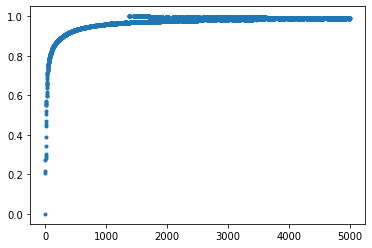

In [13]:
D = np.diag(np.sum(W, axis = 1))
L = D - W
D_prime = spl.fractional_matrix_power(D, -0.5)
I = np.identity(N)
L = I - np.dot(D_prime, np.dot(W, D_prime))
evalue, evector = npl.eig(L)
plt.plot(evalue, '.')
plt.show()
f = evector[:, 1]

In [14]:
f = f - np.median(f)
y_u = -np.sign(f)
print(1.0 * np.sum(y[-N // 2:] == y_u[-N // 2:]) / (N // 2))

0.6432


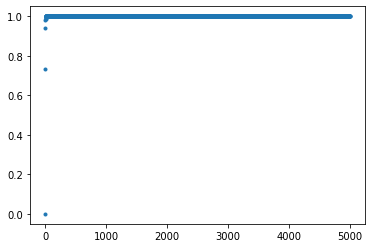

In [17]:
D = np.diag(np.sum(H, axis = 1))
L = D - H
D_prime = spl.fractional_matrix_power(D, -0.5)
I = np.identity(N)
L = I - np.dot(D_prime, np.dot(H, D_prime))
evalue, evector = npl.eig(L)
plt.plot(evalue, '.')
plt.show()
f = evector[:, 1]

In [18]:
f = f - np.median(f)
y_u = -np.sign(f)
print(1.0 * np.sum(y[-N // 2:] == y_u[-N // 2:]) / (N // 2))

0.6924


In [19]:
# num_labeled_1 = np.zeros(26)
# accuracy_1 = np.zeros(26)
# cnt = 0
# for i in range (0, N // 2 + 1, N // 50):
#     n_l = i
#     n_u = N - n_l
#     y_l = y[:n_l]
#     f_l = y_l
#     f_u = -np.dot(npl.inv(L[n_l:, n_l:]), np.dot(L[n_l:, :n_l], f_l))
#     f_u = f_u - np.median(f_u)
#     y_u = np.sign(f_u)
#     num_labeled_1[cnt] = n_l
#     accuracy_1[cnt] = 1.0 * np.sum(y[-N // 2:] == y_u[-N // 2:]) / (N // 2)
#     cnt += 1

In [20]:
I = np.identity(N)
ones = np.ones((N, N))
P = I - ones / N
W_cap = np.dot(P, np.dot(W, P))
alpha = 100000
num_labeled_2 = np.zeros(26)
accuracy_2 = np.zeros(26)
cnt = 0
for i in range (0, N // 2 + 1, N // 50):
    n_l = i
    n_u = N - n_l
    y_l = y[:n_l]
    f_l = y_l
    I_u = np.identity(n_u)
    f_u = np.dot(npl.inv(alpha * I_u - W_cap[n_l:, n_l:]), np.dot(W_cap[n_l:, :n_l], f_l))
    f_u = f_u - np.median(f_u)
    y_u = np.sign(f_u)
    num_labeled_2[cnt] = n_l
    accuracy_2[cnt] = 1.0 * np.sum(y[-N // 2:] == y_u[-N // 2:]) / (N // 2)
    cnt += 1

In [21]:
I = np.identity(N)
ones = np.ones((N, N))
P = I - ones / N
H_cap = np.dot(P, np.dot(H, P))
alpha = 100000
num_labeled_3 = np.zeros(26)
accuracy_3 = np.zeros(26)
cnt = 0
for i in range (0, N // 2 + 1, N // 50):
    n_l = i
    n_u = N - n_l
    y_l = y[:n_l]
    f_l = y_l
    I_u = np.identity(n_u)
    f_u = np.dot(npl.inv(alpha * I_u - H_cap[n_l:, n_l:]), np.dot(H_cap[n_l:, :n_l], f_l))
    f_u = f_u - np.median(f_u)
    y_u = np.sign(f_u)
    num_labeled_3[cnt] = n_l
    accuracy_3[cnt] = 1.0 * np.sum(y[-N // 2:] == y_u[-N // 2:]) / (N // 2)
    cnt += 1

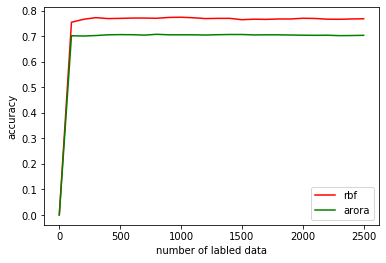

In [22]:
plt.plot(num_labeled_2, accuracy_2, 'r-', label = 'rbf')
plt.plot(num_labeled_3, accuracy_3, 'g-', label = 'arora')
plt.xlabel('number of labled data')
plt.ylabel('accuracy')
plt.legend()
plt.show()